In [1]:
from collections import defaultdict
import nltk
import os
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import machado, mac_morpho
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from collections import defaultdict
from nltk.stem.snowball import PortugueseStemmer
import enchant
from gensim import corpora, models, similarities

In [2]:
textos = []
for p, d, f in os.walk(r'machado/machado'):
    #print( p,d,f)
    if f:
        for fileid  in f:
            if not fileid.endswith('.txt'):
                continue
            with open(os.path.join(p,fileid), encoding='iso-8859-1') as g:
                textos.append(g.read())

In [3]:
swu = stopwords.words('portuguese') + list (string.punctuation)
stemmer = PortugueseStemmer()

In [4]:
#textos = textos[:4]

In [5]:
def clean_sentence(texto : str):
    return [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
textos = [*map(clean_sentence,textos)]

In [6]:
all_words = set()
for text in textos:
    all_words |= set(text)
ordered_words = list(sorted(all_words))
index_word = dict([(word,i) for i, word in enumerate(ordered_words)])

In [7]:
matrix = [[0]*len(textos) for _ in range(len(all_words))]
for i, document in enumerate(textos):
    for word in document:
        j = index_word[word]
        matrix[j][i] += 1
matrix = np.matrix(matrix)
binary_matrix = (matrix >= 1)*1

## Questão 1

In [8]:
def frequency_from(word, matrix):
    clean_word = clean_sentence(word)[0]
    if clean_word not in index_word:
        return [[0]*matrix.shape[1]]
    word_index = index_word[clean_word]
    
    line = matrix[word_index]
    return line/np.sum(line)

def binary_frequency(word):
    return frequency_from(word,binary_matrix)

def word_frequency(word):
    return frequency_from(word,matrix)

In [9]:
binary_frequency('agora')

matrix([[0.00487805, 0.        , 0.        , 0.00487805, 0.00487805,
         0.        , 0.        , 0.        , 0.00487805, 0.        ,
         0.00487805, 0.00487805, 0.        , 0.00487805, 0.        ,
         0.        , 0.00487805, 0.00487805, 0.        , 0.00487805,
         0.00487805, 0.00487805, 0.00487805, 0.00487805, 0.        ,
         0.00487805, 0.00487805, 0.        , 0.        , 0.00487805,
         0.00487805, 0.00487805, 0.00487805, 0.        , 0.        ,
         0.00487805, 0.        , 0.        , 0.00487805, 0.        ,
         0.00487805, 0.        , 0.00487805, 0.00487805, 0.00487805,
         0.        , 0.00487805, 0.00487805, 0.00487805, 0.00487805,
         0.00487805, 0.00487805, 0.00487805, 0.00487805, 0.00487805,
         0.00487805, 0.00487805, 0.00487805, 0.00487805, 0.00487805,
         0.00487805, 0.00487805, 0.00487805, 0.00487805, 0.        ,
         0.        , 0.00487805, 0.00487805, 0.00487805, 0.00487805,
         0.00487805, 0.00487805, 0

In [10]:
word_frequency('agora')

matrix([[0.00070497, 0.        , 0.        , 0.00035249, 0.00140994,
         0.        , 0.        , 0.        , 0.00035249, 0.        ,
         0.00458231, 0.00105746, 0.        , 0.00035249, 0.        ,
         0.        , 0.00070497, 0.00140994, 0.        , 0.00105746,
         0.00140994, 0.00035249, 0.00035249, 0.00035249, 0.        ,
         0.00035249, 0.00070497, 0.        , 0.        , 0.00035249,
         0.00035249, 0.00387734, 0.00105746, 0.        , 0.        ,
         0.00845964, 0.        , 0.        , 0.00140994, 0.        ,
         0.00035249, 0.        , 0.00105746, 0.00176243, 0.00035249,
         0.        , 0.00035249, 0.0024674 , 0.00035249, 0.00105746,
         0.00070497, 0.00070497, 0.01762425, 0.0024674 , 0.00281988,
         0.0024674 , 0.00669722, 0.00352485, 0.00035249, 0.00281988,
         0.00070497, 0.00317237, 0.00176243, 0.00105746, 0.        ,
         0.        , 0.02220656, 0.00140994, 0.00387734, 0.00387734,
         0.00176243, 0.00035249, 0

In [11]:
def tfdf(word):
    clean_word = clean_sentence(word)[0]
    if clean_word not in index_word:
        return [[0]*matrix.shape[1]]
    word_index = index_word[clean_word]
    line = matrix[word_index]
    quantity_words_per_doc = matrix.sum(axis=0)
    tf = line/quantity_words_per_doc
    
    freq_word = ((tf > 0)*1).sum()
    assert freq_word > 0
    df = np.log(matrix.shape[1]/freq_word)
    assert df >= 0
    return tf*df

In [12]:
tfdf('agora')

matrix([[5.87186978e-04, 0.00000000e+00, 0.00000000e+00, 1.67729123e-04,
         1.03152224e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.14956845e-04, 0.00000000e+00, 2.77766347e-04, 5.72138777e-04,
         0.00000000e+00, 3.61749121e-04, 0.00000000e+00, 0.00000000e+00,
         8.53965137e-04, 2.14559055e-04, 0.00000000e+00, 1.26612192e-03,
         2.19202353e-04, 1.10097558e-04, 3.88745324e-04, 3.95491446e-04,
         0.00000000e+00, 3.61749121e-04, 3.92384713e-05, 0.00000000e+00,
         0.00000000e+00, 1.40571748e-04, 3.01357945e-04, 1.08771945e-04,
         1.85663500e-04, 0.00000000e+00, 0.00000000e+00, 2.90783982e-04,
         0.00000000e+00, 0.00000000e+00, 7.97906157e-04, 0.00000000e+00,
         1.64550142e-04, 0.00000000e+00, 2.18961037e-04, 2.73838325e-04,
         1.75140785e-04, 0.00000000e+00, 1.00231752e-04, 4.51930205e-04,
         3.05908652e-04, 1.35387295e-04, 3.93783060e-04, 1.28124776e-04,
         3.56194187e-04, 3.43724993e-04, 3.07326687

## Questão 2

In [13]:
def get_normalized(matrix):
    squared_matrix = np.square(matrix)
    sum_rows = squared_matrix.sum(axis=0)
    matrix_sum_one = np.multiply(squared_matrix,1/sum_rows)
    normalized_matrix = np.power(matrix_sum_one,0.5)
    return normalized_matrix

In [14]:
normalized_matrix = get_normalized(matrix).T
normalized_matrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.07559289],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00498897],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [15]:
def get_cosseno_matrix(matrix):
    nlines = matrix.shape[0]
    cos_matrix = np.zeros([nlines]*2)
    for i, line_i in enumerate(matrix):
        for j, line_j in enumerate(matrix):
            cos_matrix[i,j] = (line_i*line_j.T)[0,0]
    return cos_matrix

In [16]:
cos_matrix = get_cosseno_matrix(normalized_matrix)
cos_matrix

array([[1.        , 0.33544192, 0.50979749, ..., 0.16679019, 0.47755143,
        0.18965178],
       [0.33544192, 1.        , 0.30318621, ..., 0.17178234, 0.27174403,
        0.13157763],
       [0.50979749, 0.30318621, 1.        , ..., 0.22219682, 0.5737497 ,
        0.26549094],
       ...,
       [0.16679019, 0.17178234, 0.22219682, ..., 1.        , 0.18592558,
        0.22345168],
       [0.47755143, 0.27174403, 0.5737497 , ..., 0.18592558, 1.        ,
        0.23349966],
       [0.18965178, 0.13157763, 0.26549094, ..., 0.22345168, 0.23349966,
        1.        ]])

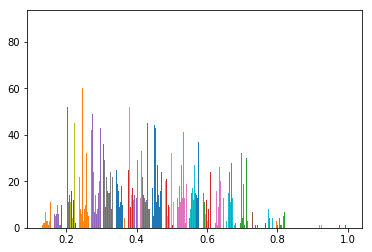

In [17]:
plt.hist(cos_matrix, bins='auto');

## Questão 3

In [18]:
dicionario = corpora.Dictionary(textos)
dicionario.save('vocabulario.dict')
dicionario

In [19]:
corpus = [dicionario.doc2bow(d) for d in textos]
corpora.MmCorpus.serialize('machado.mm', corpus)

## Questão 4

In [20]:
lsi = models.LsiModel(corpus, id2word=dicionario, num_topics=4)
index = similarities.MatrixSimilarity(lsi[corpus])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [21]:
sentence = "joao agora aqui"

In [22]:
qt = [stemmer.stem(t) for t in WordPunctTokenizer().tokenize(sentence.lower())]
print(qt)
vec_bow = dicionario.doc2bow(qt)
vec_lsi = lsi[vec_bow] # convert the query to LSI space   
vec_lsi 

['joa', 'agor', 'aqu']


[(0, 0.09771021547524841),
 (1, 0.0182218721601668),
 (2, -0.0397138303567581),
 (3, 0.08763129569674619)]

In [23]:
sims = index[vec_lsi] # perform a similarity query against the corpus
# print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims) 

[(37, 0.859715), (218, 0.85425663), (0, 0.8489985), (2, 0.8213985), (214, 0.8190739), (24, 0.81329936), (4, 0.8097189), (91, 0.80959386), (242, 0.8066619), (167, 0.80366856), (216, 0.8013319), (235, 0.7996676), (38, 0.79866517), (222, 0.7966467), (238, 0.79510665), (224, 0.79510593), (194, 0.7937019), (42, 0.7923105), (245, 0.791103), (225, 0.7908949), (30, 0.7895625), (232, 0.789495), (10, 0.7882432), (223, 0.7806411), (12, 0.7798948), (18, 0.7790223), (16, 0.77499104), (14, 0.77158034), (39, 0.7713184), (20, 0.76688147), (237, 0.7644795), (9, 0.76427156), (236, 0.761921), (233, 0.7611578), (212, 0.75837165), (174, 0.75717306), (191, 0.75607747), (197, 0.74866474), (40, 0.7484259), (192, 0.7482992), (11, 0.7453467), (23, 0.74485576), (228, 0.7437147), (196, 0.7428222), (6, 0.7410977), (43, 0.74047536), (143, 0.7387938), (44, 0.73797464), (21, 0.7371565), (90, 0.7343709), (27, 0.7335262), (241, 0.73300177), (19, 0.7312619), (230, 0.7304251), (7, 0.7303218), (13, 0.72561705), (213, 0.72

In [24]:
lsi.show_topics() 

[(0,
  '0.493*"é" + 0.300*"\x97" + 0.212*"outr" + 0.177*"a" + 0.171*"nã" + 0.160*"o" + 0.147*"tod" + 0.147*"pod" + 0.122*"cas" + 0.114*"diz"'),
 (1,
  '-0.898*"--" + 0.218*"\x97" + -0.183*"diss" + -0.135*"oliv" + 0.114*"é" + -0.104*"sr" + -0.053*"jud" + -0.048*"sik" + -0.047*"respond" + -0.045*"bumbl"'),
 (2,
  '0.701*"\x97" + -0.423*"é" + 0.161*"diss" + 0.158*"..." + 0.108*"mar" + 0.101*"rubiã" + 0.095*"capítul" + 0.094*"cas" + -0.089*"\x93" + 0.084*"mã"'),
 (3,
  '-0.402*"gilliatt" + -0.347*"o" + -0.251*"a" + -0.205*"mar" + 0.167*"..." + -0.154*"águ" + -0.150*"lethierry" + -0.141*"vent" + 0.115*"outr" + -0.115*"clubin"')]